In [ ]:
# --- Mount & Setup ---
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 495 DataScience Capstone Project/

Mounted at /content/drive
/content/drive/My Drive/CS 495 DataScience Capstone Project


In [ ]:
# --- Imports ---
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# --- Configuration ---
full_data = True
vocab_limit = 15000
enc_max_len = 64
dec_max_len = 150
max_dec_input_length = dec_max_len - 1
embedding_dim = 128
units = 128
batch = 64
epochs = 20
patience = 3
min_delta = 0.01
val_ratio = 0.2
dropout_rate = 0.3
learning_rate = 5e-5
adam_optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# --- Load dataset ---
train_df = pd.read_csv("prompt_synopsis_train.csv")
if not full_data:
    train_df = train_df.sample(n=1000, random_state=42).reset_index(drop=True)

def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

for col in ['prompt', 'synopsis']:
    train_df[col] = train_df[col].astype(str).apply(clean_text)

In [ ]:
# --- Tokenizer ---
PAD_ID, OOV_ID, BOS_ID, EOS_ID = 0, 1, 2, 3
NUM_SPECIAL_TOKENS = 4
num_words_to_fit = vocab_limit - NUM_SPECIAL_TOKENS

tokenizer = Tokenizer(num_words=num_words_to_fit, oov_token='<OOV>', filters='')
tokenizer.fit_on_texts(train_df['prompt'].tolist() + train_df['synopsis'].tolist())

new_word_index = {"<PAD>": PAD_ID, "<OOV>": OOV_ID, "<BOS>": BOS_ID, "<EOS>": EOS_ID}
new_index_word = {v: k for k, v in new_word_index.items()}
next_id = NUM_SPECIAL_TOKENS
assigned = 0

for word, original_id in sorted(tokenizer.word_index.items(), key=lambda item: item[1]):
    if word in new_word_index or assigned >= num_words_to_fit:
        continue
    new_word_index[word] = next_id
    new_index_word[next_id] = word
    next_id += 1
    assigned += 1

tokenizer.word_index = new_word_index
tokenizer.index_word = new_index_word
vocab_size = vocab_limit

with open("tokenizer_RNN-GRU_15k.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# --- Sequences ---
input_seqs = tokenizer.texts_to_sequences(train_df['prompt'])
output_seqs = tokenizer.texts_to_sequences(train_df['synopsis'])

augmented_targets = [[BOS_ID] + seq + [EOS_ID] for seq in output_seqs]
decoder_input_ids = [seq[:-1] for seq in augmented_targets]
decoder_target_ids = [seq[1:] for seq in augmented_targets]

padded_input = pad_sequences(input_seqs, maxlen=enc_max_len, padding='post', value=PAD_ID)
decoder_input_data = pad_sequences(decoder_input_ids, maxlen=max_dec_input_length, padding='post', value=PAD_ID)
decoder_target_data = pad_sequences(decoder_target_ids, maxlen=max_dec_input_length, padding='post', value=PAD_ID)
decoder_target_data = np.expand_dims(decoder_target_data, -1)

In [ ]:
# --- Split ---
X_train_enc, X_val_enc, X_train_dec, X_val_dec, y_train, y_val = train_test_split(
    padded_input, decoder_input_data, decoder_target_data, test_size=val_ratio, random_state=42
)

train_inputs = (X_train_enc, X_train_dec)
val_inputs = [X_val_enc, X_val_dec]

In [ ]:
# --- RNN-GRU Model with Dropout ---
enc_input = Input(shape=(enc_max_len,), name='encoder_input')
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(enc_input)
enc_dropout = Dropout(dropout_rate)(enc_emb)
_, enc_state = GRU(units, return_state=True, unroll=True, name='encoder_gru')(enc_dropout)

dec_input = Input(shape=(max_dec_input_length,), name='decoder_input')
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(dec_input)
dec_dropout = Dropout(dropout_rate)(dec_emb)
dec_output, _ = GRU(units, return_sequences=True, return_state=True, unroll=True, name='decoder_gru')(dec_dropout, initial_state=enc_state)
dec_dense = Dense(vocab_size, activation='softmax')(dec_output)

model = Model(inputs=[enc_input, dec_input], outputs=dec_dense)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 149)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │  1,920,000 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 149, 128)  │  1,920,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 128)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 64)        │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 149, 128)  │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_gru (GRU)   │ [(None, 128),     │     99,072 │ dropout[0][0],    │
│                     │ (None, 128)]      │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_gru (GRU)   │ [(None, 149,      │     99,072 │ dropout_1[0][0],  │
│                     │ 128), (None,      │            │ encoder_gru[0][1] │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 149,       │  1,935,000 │ decoder_gru[0][0] │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,973,144 (22.79 MB)

 Trainable params: 5,973,144 (22.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Callbacks ---
model_path = "rnn_gru_model_15k.keras"
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta, restore_best_weights=True, verbose=1)

In [ ]:
# --- Train ---
history = model.fit(
    train_inputs,
    y_train,
    batch_size=batch,
    epochs=epochs,
    validation_data=(val_inputs, y_val),
    callbacks=[checkpoint, earlystop],
    verbose=1
)

Epoch 1/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0440 - loss: 8.4651
Epoch 1: val_loss improved from inf to 6.61523, saving model to rnn_gru_model_15k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 244s 165ms/step - accuracy: 0.0441 - loss: 8.4638 - val_accuracy: 0.0531 - val_loss: 6.6152
Epoch 2/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0539 - loss: 6.6062
Epoch 2: val_loss improved from 6.61523 to 6.60581, saving model to rnn_gru_model_15k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.0539 - loss: 6.6062 - val_accuracy: 0.0531 - val_loss: 6.6058
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0540 - loss: 6.5981
Epoch 3: val_loss improved from 6.60581 to 6.60530, saving model to rnn_gru_model_15k.keras
754/754 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.0540 - loss: 6.5981 - val_accuracy: 0.0531 - val_loss: 6.6053
Epoch 4/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0538 - loss: 6.5993
Epoch 4: val_loss im

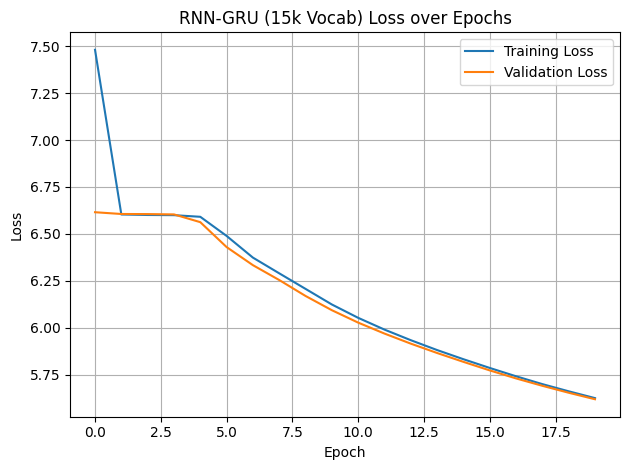

In [ ]:
# --- Plot ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN-GRU (15k Vocab) Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Final Evaluation ---
model.load_weights(model_path)
val_loss, val_acc = model.evaluate(val_inputs, y_val, verbose=0)
perplexity = np.exp(val_loss)
print(f"RNN-GRU 15k – Validation Perplexity: {perplexity:.2f}")

RNN-GRU 15k – Validation Perplexity: 275.24
